# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on August 3 (with 2-hour grace period) and worth 50 points

### Overview

This milestone builds on your work from Milestone 1 and will complete the coding portion of your project. You will:

1. Pick 3 modeling algorithms from those we have studied.
2. Evaluate baseline models using default settings.
3. Engineer new features and re-evaluate models.
4. Use feature selection techniques and re-evaluate.
5. Fine-tune for optimal performance.
6. Select your best model and report on your results. 

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



### Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling. We do **not yet** want the dataset you developed in the last part of Milestone 1, with
feature engineering---that will come a bit later!

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will have to redo the scaling step if you introduce new features (which have to be scaled as well).


In [2]:
# Add as many cells as you need

# Step 1-3
df = pd.read_csv("zillow_cleaned.csv")

In [3]:
# Step 4
X = df.drop(columns=["taxvaluedollarcnt"])   # all features
y = df["taxvaluedollarcnt"]                  # target


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=random_state
)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(62060, 22) (15516, 22) (62060,) (15516,)


In [4]:
# 5a) Numeric vs. categorical columns
numeric_cols     = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns

# 5b) Median for numerics, most frequent for categoricals
num_imp = SimpleImputer(strategy="median")
cat_imp = SimpleImputer(strategy="most_frequent")

X_train_num = pd.DataFrame(
    num_imp.fit_transform(X_train[numeric_cols]),
    columns=numeric_cols,
    index=X_train.index
)
X_test_num  = pd.DataFrame(
    num_imp.transform(X_test[numeric_cols]),
    columns=numeric_cols,
    index=X_test.index
)

X_train_cat = pd.DataFrame(
    cat_imp.fit_transform(X_train[categorical_cols]),
    columns=categorical_cols,
    index=X_train.index
)
X_test_cat  = pd.DataFrame(
    cat_imp.transform(X_test[categorical_cols]),
    columns=categorical_cols,
    index=X_test.index
)

# 5c) Scale the numeric block
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_num),
    columns=numeric_cols,
    index=X_train.index
)
X_test_num_scaled = pd.DataFrame(
    scaler.transform(X_test_num),
    columns=numeric_cols,
    index=X_test.index
)

# 5d) Ordinal‐encode to (now imputed) categoricals,
#   
encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1
)
X_train_cat_enc = pd.DataFrame(
    encoder.fit_transform(X_train_cat),
    columns=categorical_cols,
    index=X_train.index
)
X_test_cat_enc  = pd.DataFrame(
    encoder.transform(X_test_cat),
    columns=categorical_cols,
    index=X_test.index
)

# 5e) Final
X_train_scaled = pd.concat([X_train_num_scaled, X_train_cat_enc], axis=1)
X_test_scaled  = pd.concat([X_test_num_scaled, X_test_cat_enc],   axis=1)

print(X_train_scaled.shape, X_test_scaled.shape)



(62060, 22) (15516, 22)


### Part 1: Picking Three Models and Establishing Baselines [6 pts]

Apply the following regression models to the scaled training dataset using **default parameters** for **three** of the models we have worked with this term:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each of the three models:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV MAE Score**. 


In [5]:
# 3 Models are ridge, bagging, gbr
ridge = Ridge(random_state=random_state)
bagging = BaggingRegressor(random_state=random_state)
gbr = GradientBoostingRegressor(random_state=random_state)

models = [
    ("Ridge Regression", ridge),
    ("Bagging Regressor", bagging),
    ("Gradient Boosting", gbr),
]

# Repeated CV (5 folds x 5 repeats)
rkf = RepeatedKFold(
    n_splits=5,
    n_repeats=5,
    random_state=random_state
)

# Evaluate each model
for name, model in models:
    neg_mae_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        scoring="neg_mean_absolute_error",
        cv=rkf,
        n_jobs=-1
    )
    mae_scores = -neg_mae_scores  
    print(f"{name:20s} → MAE: {mae_scores.mean():.0f} ± {mae_scores.std():.0f}")


Ridge Regression     → MAE: 243773 ± 3343
Bagging Regressor    → MAE: 198207 ± 2761
Gradient Boosting    → MAE: 200104 ± 2555


In [6]:
# Added Random Forest to test (all had high MAE)
rf = RandomForestRegressor(random_state=random_state)

neg_mae = cross_val_score(
    rf,
    X_train_scaled,     
    y_train,
    scoring="neg_mean_absolute_error",
    cv=rkf,              
    n_jobs=-1
)
mae = -neg_mae
print(f"Random Forest → MAE: {mae.mean():.0f} ± {mae.std():.0f}")


Random Forest → MAE: 190862 ± 2583


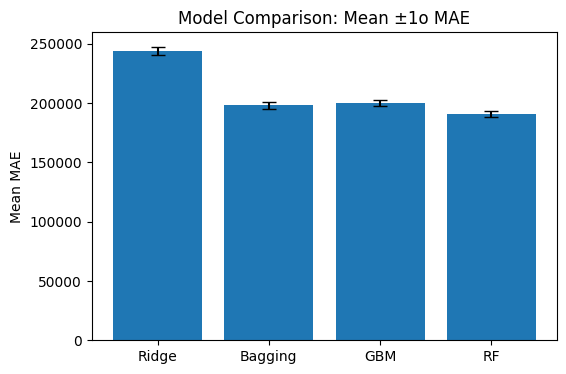

In [7]:
#Bar Chart to compare / evaluate 

models = ["Ridge", "Bagging", "GBM", "RF"]
means  = [244000, 198000, 200000, 191000]  # your exact means
stds   = [3300,   2760,   2555,   2583]    # your exact stds

plt.figure(figsize=(6,4))
plt.bar(models, means, yerr=stds, capsize=5)
plt.ylabel("Mean MAE")
plt.title("Model Comparison: Mean ±1o MAE")
plt.show()


### Part 1: Discussion [3 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which model performed best overall?
  - Which was most stable (lowest std)?
  - Any signs of overfitting or underfitting?

The Random Forest Model was the best overall performer in terms of mean absolute error with roughly 191,000 and it had the smallest standard deviation with 2,600. The worst performer was the Ridge model with approximately 244,000 in terms of MAE and was the least stable at 3,300 standard deviation. This makes sense because of the numerous complex variables used in predicting house prices that it would not be simple enought to fit a linear model like the ridge for this situation. I decided to try a fourth model with the random forest because the MAE were all very large for the first three models selected and I wanted to explore more. While the random forest helped improve the MAE there were no large indicators that any of these models were over-fitting in the cross validation. The argument could actually be made that the models are underfitting the data given the complexity of prediction at hand.    

### Part 2: Feature Engineering [6 pts]

Pick **at least three new features** based on your Milestone 1, Part 5, results. You may pick new ones or
use the same ones you chose for Milestone 1. 

Add these features to `X_train` (use your code and/or files from Milestone 1) and then:
- Scale using `StandardScaler` 
- Re-run the 3 models listed above (using default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [ ]:
#Feature Engineering 1: Ratio feature (Bath to Bed Ratio) 

#Train
X_train_num['bath_to_bed_ratio'] = X_train_num['fullbathcnt'] * X_train_num['bedroomcnt']

#Test
X_test_num['bath_to_bed_ratio'] = X_test_num['fullbathcnt'] * X_test_num['bedroomcnt']


In [ ]:
#Feature Engineeing 2: Square Feet & Bathroom Interaction

#Train
X_train_num['sqft_bath_interaction'] = X_train_num['calculatedfinishedsquarefeet'] * X_train_num['fullbathcnt']

#Test
X_test_num['sqft_bath_interaction'] = X_test_num['calculatedfinishedsquarefeet'] * X_test_num['fullbathcnt']



In [ ]:
#Feature Engineering 3: Sqaure feet & Property Type Interaction

#Train
X_train_num['sqft_vs_type_average'] = X_train_num['calculatedfinishedsquarefeet'] / X_train_num['propertylandusetypeid'].map(X_train_num.groupby('propertylandusetypeid')['calculatedfinishedsquarefeet'].mean())

#Test
X_test_num['sqft_vs_type_average'] = X_test_num['calculatedfinishedsquarefeet'] / X_test_num['propertylandusetypeid'].map(X_test_num.groupby('propertylandusetypeid')['calculatedfinishedsquarefeet'].mean())


In [47]:
#Add new features to numeric_cols
numeric_cols_list = list(numeric_cols)
numeric_cols_list.extend(['bath_to_bed_ratio', 'sqft_bath_interaction', 'sqft_vs_type_average'])
numeric_cols = pd.Index(numeric_cols_list)
numeric_cols = numeric_cols.drop_duplicates()

In [56]:
#New train and test sets with new features
X_train_num_scaled2 = pd.DataFrame(
    scaler.fit_transform(X_train_num),
    columns=numeric_cols,
    index=X_train.index
)

In [57]:
X_test_num_scaled2 = pd.DataFrame(
    scaler.transform(X_test_num),
    columns=numeric_cols,
    index=X_test.index

)

In [ ]:
#Running models Fujnction

def evaluate_models(models, X_data, y_data, cv_folds=None):
  
    if cv_folds is None:
        cv_folds = RepeatedKFold(
            n_splits=5,
            n_repeats=5,
            random_state=random_state
        )
    
    results = {}
    
    for name, model in models.items():
        neg_mae_scores = cross_val_score(
            model,
            X_data,
            y_data,
            scoring="neg_mean_absolute_error",
            cv=cv_folds,
            n_jobs=-1
        )
        mae_scores = -neg_mae_scores
        results[name] = {
            'mae_scores': mae_scores,
            'mean_mae': mae_scores.mean(),
            'std_mae': mae_scores.std()
        }
        print(f"{name:20s} -> MAE: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")
    
    return results


In [62]:
models_dict = {
    "Ridge Regression": ridge,
    "Bagging Regressor": bagging, 
    "Gradient Boosting": gbr
}

In [64]:
evaluate_models(models_dict,X_train_num_scaled2, y_train )

Ridge Regression     -> MAE: 230466.011 ± 3225.957
Bagging Regressor    -> MAE: 198443.023 ± 2403.191
Gradient Boosting    -> MAE: 200116.990 ± 2430.064


{'Ridge Regression': {'mae_scores': array([228778.52926018, 229568.7393022 , 231279.2329585 , 234894.02588305,
         227817.93760318, 226357.00712834, 229929.53491438, 232975.60021808,
         231052.30314423, 232352.91760562, 224211.64737391, 234652.01635845,
         231220.55380712, 228012.30569697, 234129.36840192, 233121.64143302,
         228078.26082543, 233090.70251096, 232020.05128207, 225849.92974243,
         235313.78151528, 226976.04005409, 233745.2296898 , 231598.91481065,
         224624.00410142]),
  'mean_mae': np.float64(230466.01102485112),
  'std_mae': np.float64(3225.9571177426187)},
 'Bagging Regressor': {'mae_scores': array([195125.68679429, 199494.15177043, 202574.92063674, 199954.18850823,
         195934.38170875, 194873.30671115, 199117.79629428, 200180.85788712,
         199098.03883237, 202179.46128861, 194259.10465886, 202703.88728052,
         199089.49394894, 195202.58894152, 201437.55797236, 198451.57091556,
         196893.53078655, 200148.16012639

### Part 2: Discussion [3 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?




> Your text here

### Part 3: Feature Selection [6 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features (with default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [69]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [70]:
#Forward Selection Function
def forward_selection(X, y, max_features=5):
    selected_features = []
    remaining_features = list(X.columns)
    
    for _ in range(max_features):
        best_score = -np.inf
        best_feature = None
        
        for feature in remaining_features:
            # Test adding this feature
            test_features = selected_features + [feature]
            X_subset = X[test_features]
            
            # Cross-validation score
            model = LogisticRegression(random_state=42)
            scores = cross_val_score(model, X_subset, y, cv=5, scoring='accuracy')
            avg_score = scores.mean()
            
            if avg_score > best_score:
                best_score = avg_score
                best_feature = feature
        
        if best_feature:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            print(f"Added {best_feature}, Score: {best_score:.4f}")
    
    return selected_features

In [71]:
forward_features = forward_selection(X_train_num_scaled2,y_train)


C:\Users\ljkap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:2734: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  and (type_of_target(y, input_name="y") in ("binary", "multiclass"))
C:\Users\ljkap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:784: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_of_target_y = type_of_target(y)
C:\Users\ljkap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ljkap\AppData\Local\Packages\PythonSoftwareFoundation.Pytho

KeyboardInterrupt: 

In [ ]:
#Backward Selection Function
def backward_elimination(X, y, min_features=5):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import cross_val_score
    
    features = list(X.columns)  # Start with all features
    
    while len(features) > min_features:
        best_to_remove = None
        smallest_drop = float('inf')
        
        # Test removing each feature
        for feature in features:
            # Try without this feature
            remaining = [f for f in features if f != feature]
            score = cross_val_score(LogisticRegression(random_state=42), 
                                  X[remaining], y, cv=5).mean()
            
            # Current score with all features
            current_score = cross_val_score(LogisticRegression(random_state=42), 
                                          X[features], y, cv=5).mean()
            
            drop = current_score - score  # How much we lose
            
            if drop < smallest_drop:  # Find least harmful
                smallest_drop = drop
                best_to_remove = feature
        
        # Remove the least harmful feature
        features.remove(best_to_remove)
        print(f"Removed {best_to_remove}")
    
    return features


In [ ]:
backward_features = backward_elimination(X_train_num_scaled2,y_train)

#### Re-Run Models

In [ ]:
forward_model_performance = evaluate_models(models_dict,X_train_num_scaled2[forward_features], y_train[forward_features] )

In [ ]:
backward_model_performance = evaluate_models(models_dict,X_train_num_scaled2[backward_features], y_train[backward_features] )

### Part 3: Discussion [3 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?


> Your text here

### Part 4: Fine-Tuning Your Three Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far, and pick a winner!

1. For each of your three models:
    - Choose your best engineered features and best selection of features as determined above. 
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, `Optuna`, etc. as you have practiced in previous homeworks. 
3. Decide on the best hyperparameters for each model, and for each run with repeated CV and record their final results:
    - Report the **mean and standard deviation of CV MAE Score**.  

In [10]:
# Add as many cells as you need


### Part 4: Discussion [3 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?


> Your text here

### Part 5: Final Model and Design Reassessment [6 pts]

In this part, you will finalize your best-performing model.  You’ll also consolidate and present the key code used to run your model on the preprocessed dataset.
**Requirements:**

- Decide one your final model among the three contestants. 

- Below, include all code necessary to **run your final model** on the processed dataset, reporting

    - Mean and standard deviation of CV MAE Score.
    
    - Test score on held-out test set. 




In [11]:
# Add as many cells as you need


### Part 5: Discussion [8 pts]

In this final step, your goal is to synthesize your entire modeling process and assess how your earlier decisions influenced the outcome. Please address the following:

1. Model Selection:
- Clearly state which model you selected as your final model and why.

- What metrics or observations led you to this decision?

- Were there trade-offs (e.g., interpretability vs. performance) that influenced your choice?

2. Revisiting an Early Decision

- Identify one specific preprocessing or feature engineering decision from Milestone 1 (e.g., how you handled missing values, how you scaled or encoded a variable, or whether you created interaction or polynomial terms).

- Explain the rationale for that decision at the time: What were you hoping it would achieve?

- Now that you've seen the full modeling pipeline and final results, reflect on whether this step helped or hindered performance. Did you keep it, modify it, or remove it?

- Justify your final decision with evidence—such as validation scores, visualizations, or model diagnostics.

3. Lessons Learned

- What insights did you gain about your dataset or your modeling process through this end-to-end workflow?

- If you had more time or data, what would you explore next?

> Your text here